In [9]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from scipy import sparse

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
cols = ['BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY',
       'TAX CLASS AT PRESENT', 'BLOCK', 'LOT', 'EASE-MENT',
       'BUILDING CLASS AT PRESENT', 'ADDRESS', 'APARTMENT NUMBER', 'ZIP CODE',
       'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS',
       'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT',
       'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE',
       'SALE PRICE', 'SALE DATE']
cols = [col.lower().replace(" ","_") for col in cols]

Download all real estate transaction data from NYC.gov for January 2010 to May 2020. Only closed transactions are included. Column names in all files are the same but sometimes have trailing white space. Convert to lower case for easier use.

In [21]:
# from https://www1.nyc.gov/site/finance/taxes/property-annualized-sales-update.page
# ex: https://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/annualized-sales/2019/2019_manhattan.xlsx
url_prefix = 'https://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales'
years = range(2010,2020)
links = [f"{url_prefix}/annualized-sales/{year}/{year}_manhattan.xls{'x' if year > 2017 else ''}" for year in years ]
links += [url_prefix + "/rollingsales_manhattan.xls"]

Exclude any transaction with sale price under \$100,000 as it might not be an arms length transaction or just bad data. The very last file we downloaded covers period of May 2019 - April 2020, so we need to remove duplicates in April 2019 - December 2019.

In [22]:
dfs = [pd.read_excel(link, skiprows=4, names=cols, parse_dates=[20]) for link in links]
df = pd.concat(dfs).drop_duplicates()
df = df[(df.sale_price > 100000)]
df = df[['neighborhood', 'block','lot', 'address', 'apartment_number', 'gross_square_feet', 'sale_price', 'year_built', 'sale_date']]
df.neighborhood = df.neighborhood.str.strip().str.lower()

Generate a unique ID for each unit by combining the block and unit numbers. We convert transaction periods to quarters (our index will be quarterly as a result). If the same house sold multiple times in the same quarter, remove the first transaction(s) and only keep the last transaction. This most likely represents a contractor flip.

In [23]:
df['uid'] = df.block.map(str) + '_' + df.lot.map(str)
df['period'] = pd.PeriodIndex(df.sale_date, freq='Q')
df = df.drop_duplicates(subset=['period','uid'],keep='last')

In [24]:
''' Function takes in DataFrame rpt_sales with columns `uid`, `period`, and `sale_price`. 
    Returns:
        design matrices X, W, and Z as specified in the Case Shiller index methodology
        array deltaT:    number of periods elapsed between each sale pair
        array uid_key:   for each row of matrices, which house it represents
        array periods:   list of all unique periods, so columns can be converted to Periods 
'''
def createDesignMatrices(rpt_sales):
    grouped = rpt_sales.groupby('uid')
    S = np.sum(grouped.size()-1)
    periods = list(rpt_sales.period.unique())
    T = len(periods)

    # construct blank design matrices
    X = np.zeros((S, T))
    deltaT = np.zeros((S,1))
    
    uid_key = []
    row = 0
    for house, group in grouped:
      for i in range(len(group)-1):
        first = (group.iloc[i].sale_price, periods.index(group.iloc[i].period))
        second = (group.iloc[i+1].sale_price, periods.index(group.iloc[i+1].period))

        X[row,first[1]] = -first[0]
        X[row,second[1]] = second[0]
        deltaT[row] = second[1] - first[1]

        uid_key.append(house)
        row += 1

    W = np.reshape(-X[:,0],(-1,1))
    X = X[:,1:]
    Z = np.sign(X)

    return sparse.csr_matrix(X), W, sparse.csr_matrix(Z), deltaT, uid_key, periods

'''
    Constructs Case Shiller repeat sales index
    inputs: X,Z,W - design matrices as specified in the Case Shiller methodology
            periods - array of all periods in the sample
    outputs: DataFrame with index of periods and columns `weighted` and `unweighted` for the house price index
            first period index value is guaranteed to be 1.0 by convention
'''
def buildIndex(X, Z, W, periods):
    #1) Estimate b by running regression using instrumental variables b = (Z'X)^-1 x X'w
    coeff = sparse.linalg.inv(Z.T * X) * Z.T * W
    #coeff = np.linalg.inv(Z.T.dot(X)).dot(Z.T).dot(W)
    idx = 1/(coeff.reshape(X.shape[1]))
    unweighted = pd.DataFrame([1,*idx], index=periods, columns=['unweighted'])

    #2) Calculate weights for each observation 
    resid = W - X.dot(coeff)
    reg = LinearRegression().fit(deltaT, resid**2)
    weights = np.sqrt(reg.predict(deltaT).clip(min=0.00001))
    Omega = sparse.diags(np.reshape(1/weights,X.shape[0]))
    #Omega = np.diag(np.reshape(1/weights,X.shape[0]))

    #3) Estimate b again incorporating weights b = (Z'OmegaX)^-1 x Z'Omega w
    coeff_weighted = sparse.linalg.inv(Z.T * Omega * X) * Z.T * Omega * W
    idx_weighted = 1/(coeff_weighted.reshape(X.shape[1]))
    weighted = pd.DataFrame([1,*idx_weighted],index=periods, columns=['weighted'])

    return pd.concat([unweighted, weighted], axis=1), weights

   period  uid  sale_price
0       0    1          10
1       1    1           9
2       0    2          12
3       1    2          11
4       0    3          10
5       2    3          12
6       0    4           7
7       2    4           8
8       1    5          10
9       2    5          15
X   (0, 0)	9.0
  (1, 0)	11.0
  (2, 1)	12.0
  (3, 1)	8.0
  (4, 0)	-10.0
  (4, 1)	15.0 

W [[10.]
 [12.]
 [10.]
 [ 7.]
 [-0.]] 

Z   (0, 0)	1.0
  (1, 0)	1.0
  (2, 1)	1.0
  (3, 1)	1.0
  (4, 0)	-1.0
  (4, 1)	1.0 

deltaT [[1.]
 [1.]
 [2.]
 [2.]
 [1.]]


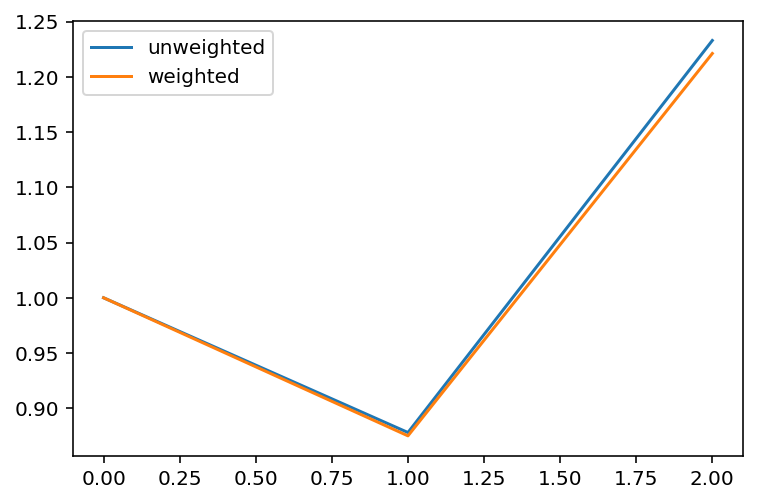

In [25]:
# create a dummy test case to test
dummy = pd.DataFrame({'period': [0,1,0,1,0,2,0,2,1,2], 'uid': [1,1,2,2,3,3,4,4,5,5], 'sale_price': [10, 9, 12,11,10,12,7,8,10,15]})
print(dummy)

X, W, Z, deltaT, uid_key, periods = createDesignMatrices(dummy)
print("X", X,"\n\nW",W,"\n\nZ",Z, "\n\ndeltaT", deltaT)
idx,weights = buildIndex(X,Z,W, periods)
idx.plot()

Filter for only homes that have sold more than once (not technically required but reduces memory usage), sort by date

In [26]:
rpt_sales = df[['period', 'uid', 'sale_price', 'neighborhood', 'sale_date']] \
                .groupby('uid') \
                .filter(lambda x: len(x) >= 2) \
                .sort_values('sale_date')

Build design matrices, and construct the index values. Indices are constructed using the repeat sales methodology, meaning that we only look at homes that have sold several times and track the percentage change in price between the first sale and the next sale, which ideally represents an apples-to-apples comparison. See Case Shiller methodology for full description. Known issues is that if the house was remodeled or otherwise improved, we don't have this information so it wouldn't get incorporated. But homes also on average lose value to depreciation/age, and with thousands of transactions this represents the best price comparison possible.

In [27]:
X, W, Z, deltaT, uid_key, periods = createDesignMatrices(rpt_sales)
idx, weights = buildIndex(X, Z, W, periods)

Plot the weighted house price index along with a 1-year/4-quarter rolling average.

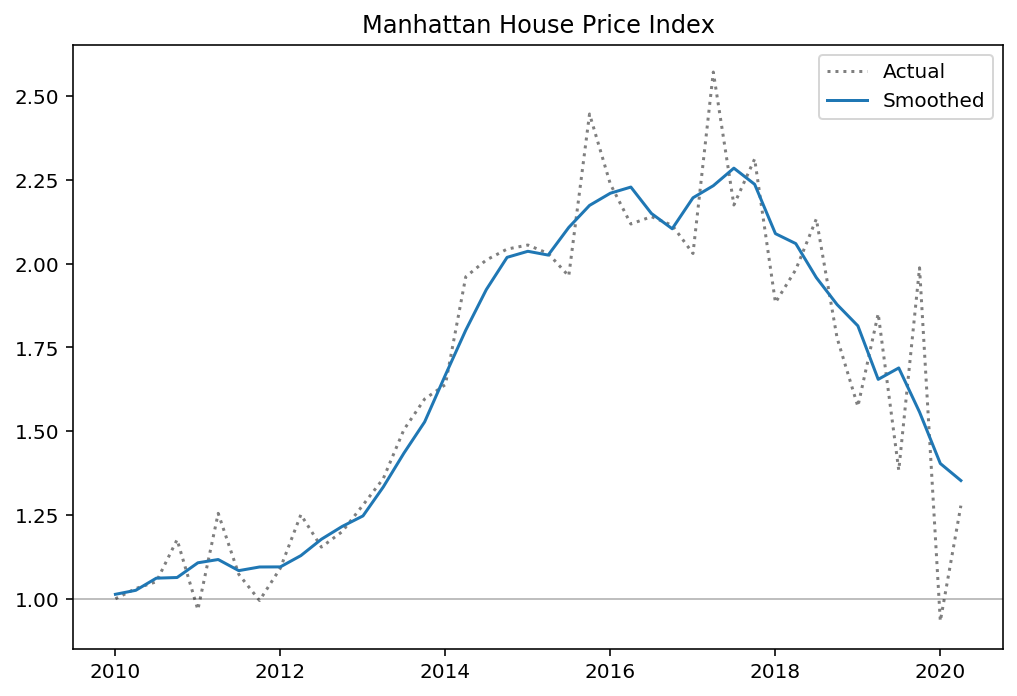

In [28]:
def plot_idx(result, ax, area_name):
    index = result.index.to_timestamp()
    ax.set_title(f"{area_name} House Price Index")

    ax.plot(index, result.weighted.values, 
                   c='k',
                   linestyle=':',
                   alpha=.5, label="Actual")

    ax.plot(index, result.smoothed.values, label="Smoothed")
    
    ax.axhline(1.0, c='k', lw=1, alpha=.25)
    ax.legend()


smoothed = idx.weighted.rolling(4,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).rename("smoothed")

fig, ax = plt.subplots(figsize=(600/72,400/72))
plot_idx(pd.concat([idx, smoothed], axis=1), ax, "Manhattan")

Combine some of the smaller neighborhoods together and eliminate very tiny neighborhoods. FYI, Javits Center is basically Hudson Yards but sadly only has 119 datapoints.

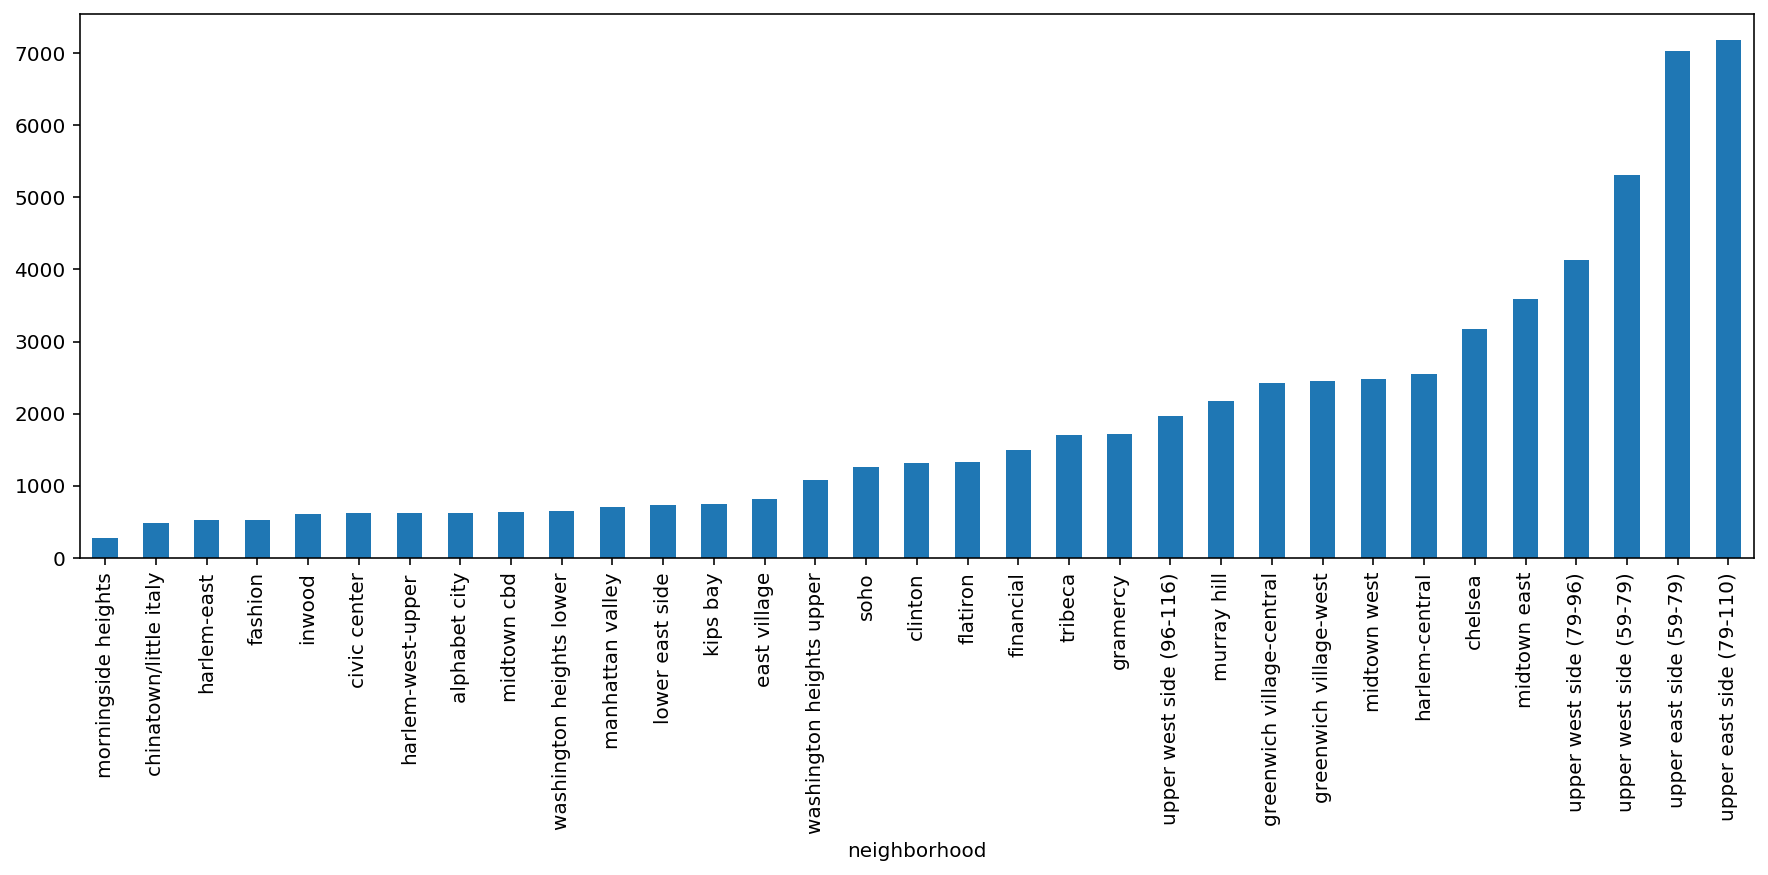

In [29]:
# exclude neighborhoods with very few datapoints
FILTERED_NEIGHBORHOODS=['manhattan-unknown', 'roosevelt island']
COMBINED_NEIGHBORHOODS = {
    'chinatown':                 'chinatown/little italy',
    'little italy':              'chinatown/little italy',
    'javits center':             'clinton',
    'southbridge':               'financial',
    'harlem-west':               'harlem-west-upper',
    'harlem-upper':              'harlem-west-upper',
    'upper east side (96-110)':  'upper east side (79-110)',
    'upper east side (79-96)':   'upper east side (79-110)',
}
filtered = rpt_sales.neighborhood.isin(FILTERED_NEIGHBORHOODS)
grouped = rpt_sales[~filtered].replace({"neighborhood": COMBINED_NEIGHBORHOODS}).groupby('neighborhood')
grouped.size().sort_values().plot.bar(figsize=(15,5))

Create index values for every neighborhood, along with rolling averages

In [ ]:
results = None
for row, (name, group) in enumerate(grouped):
    X, W, Z, deltaT, uid_key, periods = createDesignMatrices(group)
    try:
        idx,weights = buildIndex(X,Z,W, periods)
        idx['neighborhood'] = name
        
        smoothed = idx.weighted.rolling(4,
            win_type='gaussian',
            min_periods=1,
            center=True).mean(std=2).rename("smoothed")
        
        idx = pd.concat([idx,smoothed], axis=1)
        
        if results is None:
            results = idx
        else:
            results = pd.concat([results, idx])
        
    except Exception as e:
        print(name, e)

Display graph indices for all neighborhoods, in alphabetical order

In [ ]:
ncols = 3
nrows = int(np.ceil(len(results.groupby('neighborhood').groups) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

for row, (name, idx) in enumerate(results.groupby('neighborhood')):
    plot_idx(idx, axes.flat[row], name)
                                  
fig.tight_layout()

Calculate year over year growth for each neighborhood and plot it below

In [ ]:
mr = results.set_index('neighborhood',append=True).weighted.unstack('neighborhood').pct_change(4).iloc[-1]
mr.sort_values(inplace=True)
figsize= (15,2.5)
fig, ax = plt.subplots(figsize=figsize)
ax.set_title("Change in Housing Prices, Q2'2019-Q2'2020")
bars = ax.bar(mr.index, mr, width=.825, capsize=2)
    
ax.set_xticklabels(mr.index, rotation=90, fontsize=11)
ax.axhline(0.0, linestyle=':', color='k', lw=1)
mr